<a href="https://colab.research.google.com/github/Anushka-Punukollu/StockPricePrediction-LSTM/blob/main/StockPricePredictionML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Description : This program using an  LSTM to predict the closing stock price of a coropration (Microsoft Corp) using the past 5 years of its stock price data.

In [ ]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from copy import deepcopy

df = pd.read_csv('MSFT.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060809,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062980,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064067,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062437,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061351,47894400
...,...,...,...,...,...,...,...
9274,2022-12-28,236.889999,239.720001,234.169998,234.529999,234.529999,17457100
9275,2022-12-29,235.649994,241.919998,235.649994,241.009995,241.009995,19770700
9276,2022-12-30,238.210007,239.960007,236.660004,239.820007,239.820007,21930800
9277,2023-01-03,243.080002,245.750000,237.399994,239.580002,239.580002,25740000


In [ ]:
df = df[['Date', 'Close']]

df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9274,2022-12-28,234.529999
9275,2022-12-29,241.009995
9276,2022-12-30,239.820007
9277,2023-01-03,239.580002


In [ ]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [ ]:
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9274,2022-12-28,234.529999
9275,2022-12-29,241.009995
9276,2022-12-30,239.820007
9277,2023-01-03,239.580002


In [ ]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-26-f6fc52bb0fa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9274   2022-12-28
9275   2022-12-29
9276   2022-12-30
9277   2023-01-03
9278   2023-01-04
Name: Date, Length: 9279, dtype: datetime64[ns]

In [ ]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2022-12-28,234.529999
2022-12-29,241.009995
2022-12-30,239.820007


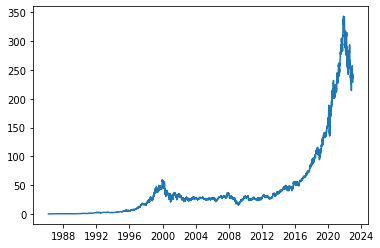

In [ ]:
plt.plot(df.index, df['Close'])

In [ ]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2018-01-01', 
                                '2023-01-04', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2018-01-01,85.400002,85.709999,85.720001,85.540001
1,2018-01-03,85.720001,85.540001,85.949997,86.349998
2,2018-01-04,85.540001,85.949997,86.349998,87.110001
3,2018-01-05,85.949997,86.349998,87.110001,88.190002
4,2018-01-08,86.349998,87.110001,88.190002,88.279999
...,...,...,...,...,...
1256,2022-12-28,238.190002,238.729996,236.960007,234.529999
1257,2022-12-29,238.729996,236.960007,234.529999,241.009995
1258,2022-12-30,236.960007,234.529999,241.009995,239.820007
1259,2023-01-03,234.529999,241.009995,239.820007,239.580002


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1261,), (1261, 3, 1), (1261,))

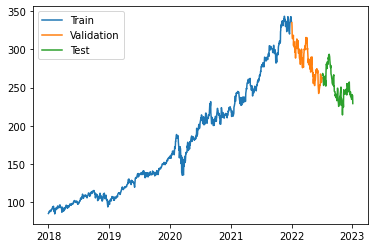

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
32/32 [==============================] - 3s 26ms/step - loss: 35497.4570 - mean_absolute_error: 174.5325 - val_loss: 81185.0625 - val_mean_absolute_error: 284.1837
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 34274.2070 - mean_absolute_error: 170.9508 - val_loss: 77339.0312 - val_mean_absolute_error: 277.3331
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 29015.0176 - mean_absolute_error: 154.1607 - val_loss: 59483.1484 - val_mean_absolute_error: 243.0050
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 15198.1992 - mean_absolute_error: 99.2134 - val_loss: 28188.9648 - val_mean_absolute_error: 166.6090
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 5802.6919 - mean_absolute_error: 60.4707 - val_loss: 12144.2080 - val_mean_absolute_error: 108.2575
Epoch 6/100
32/32 [==============================] - 0s 7ms/step - loss: 4647.4380 - mean_absolute_error: 58.5685 - val_loss: 1

32/32 [==============================] - 1s 2ms/step


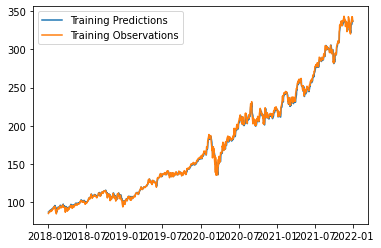

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

4/4 [==============================] - 0s 3ms/step


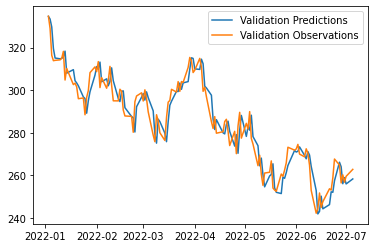

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

4/4 [==============================] - 0s 4ms/step


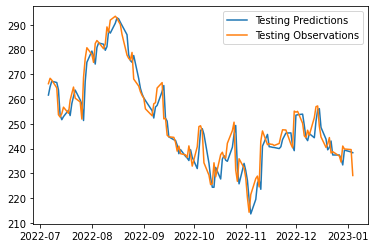

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

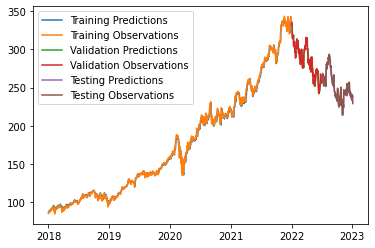

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])